In [1]:
using LinearAlgebra
using Plots

In [2]:
fi = ComplexF32(1.0im)

0.0f0 + 1.0f0im

In [3]:
function vec2hermite(v::Vector{Float32})
    N = round(Int, sqrt(length(v)))
    H = zeros(ComplexF32, N, N)
    for i in 1:N
        for j in i:N
            l = N*(i-1) + 2j - i^2
            if(i == j)
                H[i,j] = v[l]
            else
                H[i,j] = v[l-1] + fi*v[l]
            end 
        end
    end
    H = Hermitian(H)
    return H
end

vec2hermite (generic function with 1 method)

In [4]:
function vec2unitary(v::Vector{Float32}, τ::Float32)
    H = vec2hermite(v)
    U = exp(fi*(τ*H))
    return U
end

vec2unitary (generic function with 1 method)

In [5]:
function make_unitary(N::Int, τ::Float32)
    v = rand(Float32, N^2)
    U = vec2unitary(v, τ)
    return U
end

make_unitary (generic function with 1 method)

In [41]:
function norm!(m::Hermitian{ComplexF32, Matrix{ComplexF32}})
    T = real(tr(m))
    m = m/T
end

norm! (generic function with 1 method)

In [42]:
function norm(m::Hermitian{ComplexF32, Matrix{ComplexF32}})
    T = real(tr(m))
    return m/T
end

norm (generic function with 1 method)

4-element Vector{Float32}:
 0.13625076
 0.4110931
 0.19927171
 0.31276777

In [7]:
function make_rand_dm(dim::Int)
    ρ_vec = rand(Float32, dim^2)
    rt_ρ = vec2hermite(ρ_vec)
    ρ = Hermitian(norm!(Hermitian(rt_ρ*rt_ρ')))
    return ρ
end

make_rand_dm (generic function with 1 method)

In [8]:
test_U = make_unitary(4, 1.0f0)
II = test_U * test_U'
println([real(II[i,i]) for i in 1:4])

Float32[0.99999994, 0.99999994, 0.9999999, 0.99999994]


In [9]:
function ehot(vs::Vector{ComplexF32}, i::Int, e_dim::Int)
    s_dim = length(vs)
    ve = zeros(ComplexF32, e_dim*s_dim)
    ve[(s_dim*(i-1)+1):(s_dim*i)] = vs
    #v2 = vcat(vs, ve)
    return ve
end

ehot (generic function with 1 method)

In [10]:
function make_ev(s_ev::Matrix{ComplexF32}, e_dim::Int)
    #e_vec::Vector{Matrix{Float32}} = []
    s_vec::Vector{Matrix{ComplexF32}} = []
    s_dim = size(s_ev)[1]
    tot_dim = s_dim * e_dim
    println(s_dim)
    for i in 1:s_dim
        sm = zeros(ComplexF32, tot_dim, e_dim)
        for j in 1:e_dim
            sm[:,j] = ehot(s_ev[:,i], j, e_dim)
            #push!(e_vec, twohot(i, j, s_dim))
            #push!(s_vec, ehot(s_ev[:,i], j, e_dim))
        end
        push!(s_vec, sm)
    end
    #=
    for j in 1:e_dim
        em = zeros(Float32, tot_dim, s_dim)
        for i in 1:s_dim
            em[:,i] = twohot(i, j, s_dim, e_dim)
        end
        push!(e_vec, em)
    end=#
    return s_vec
end

make_ev (generic function with 1 method)

In [11]:
function make_Mk(U::Matrix{ComplexF32}, s_vec::Vector{Matrix{ComplexF32}})
    L = size(U)[1]
    e_dim = length(s_vec)
    s_dim = div(L,e_dim)
    Ms::Vector{Matrix{ComplexF32}} = []
    for j in 1:e_dim
        for k in 1:s_dim
            push!(Ms, (s_vec[k]'*U*s_vec[j]))
        end
    end
    return Ms
end

make_Mk (generic function with 1 method)

In [25]:
#=
function make_Mk(U::Matrix{ComplexF32}, s_vec::Vector{Matrix{ComplexF32}}, e_vec::Vector{Matrix{Float32}})
    L = size(U)[1]
    e_dim = length(s_vec)
    s_dim = div(L,e_dim)
    Ms::Vector{Matrix{ComplexF32}} = []
    for j in 1:e_dim
        for k in 1:s_dim
            push!(Ms, (e_vec[k]'*U*s_vec[j]))
        end
    end
    return Ms
end=#

make_Mk (generic function with 1 method)

In [12]:
struct Dime
    s_dim::Int
    e_dim::Int
    tot_dim::Int
    M_size::Int
end

In [13]:
dim = Dime(2, 2, 4, 16)

Dime(2, 2, 4, 16)

In [14]:
function Λρ(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, Ms::Vector{Matrix{ComplexF32}}, es::Vector{Float32}, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:tot_dim
        Lρ += es[div(i-1,ds.e_dim)+1]*Ms[i]'*ρ*Ms[i]
    end
    return Hermitian(Lρ)
end

Λρ (generic function with 1 method)

In [15]:
testm = make_rand_dm(2)

2×2 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.793846+0.0im       0.301093+0.252951im
 0.301093-0.252951im  0.206154+0.0im

In [16]:
function KL_divergence(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, σ::Hermitian{ComplexF32, Matrix{ComplexF32}})
    return real(tr(ρ*(log(ρ)-log(σ))))
end

KL_divergence (generic function with 1 method)

In [17]:
struct DMs
    s_dm::Hermitian{ComplexF32, Matrix{ComplexF32}}
    e_dm::Hermitian{ComplexF32, Matrix{ComplexF32}}
    s_evs::Matrix{ComplexF32}
    s_es::Vector{Float32}

    U::Matrix{ComplexF32}
    Ms::Vector{Matrix{ComplexF32}}
end

function init_dms(ds::Dime, τ::Float32)
    s_dm = make_rand_dm(ds.s_dim)
    e_dm = make_rand_dm(ds.e_dim)
    s_es, s_evs = eigen(s_dm)
    U = make_unitary(ds.tot_dim, τ)
    s_evsa = make_ev(s_evs, ds.e_dim)
    Ms = make_Mk(U, s_evsa)
    return DMs(s_dm, e_dm, s_evs, s_es, U, Ms)
end

init_dms (generic function with 1 method)

In [18]:
function Λρ(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:ds.tot_dim
        Lρ += dms.s_es[div(i-1,ds.e_dim)+1]*dms.Ms[i]*ρ*dms.Ms[i]'
    end
    return Hermitian(Lρ)
end

Λρ (generic function with 2 methods)

In [19]:
function Λρd(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:ds.tot_dim
        Lρ += dms.s_es[div(i-1,ds.e_dim)+1]*dms.Ms[i]'*ρ*dms.Ms[i]
    end
    return Hermitian(Lρ)
end

Λρd (generic function with 1 method)

In [64]:
function Λρ2(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:tot_dim
        Lρ += dms.s_es[((i-1)%ds.s_dim)+1]*dms.Ms[i]*ρ*dms.Ms[i]'
    end
    return Hermitian(Lρ)
end

Λρ2 (generic function with 1 method)

In [20]:
test_dms = init_dms(dim, 1.0f0)

2


DMs(ComplexF32[0.43760204f0 + 0.0f0im 0.15425375f0 + 0.23607332f0im; 0.15425375f0 - 0.23607332f0im 0.5623979f0 + 0.0f0im], ComplexF32[0.45353186f0 + 0.0f0im 0.2824309f0 + 0.31362054f0im; 0.2824309f0 - 0.31362054f0im 0.54646814f0 + 0.0f0im], ComplexF32[0.42652422f0 + 0.6527621f0im 0.3424645f0 + 0.5241152f0im; -0.626082f0 + 0.0f0im 0.7797572f0 + 0.0f0im], Float32[0.21117765, 0.7888223], ComplexF32[0.37122726f0 - 0.08254771f0im -0.6642448f0 + 0.12845823f0im -0.4379226f0 - 0.43552116f0im 0.12726684f0 - 0.0013786973f0im; 0.36490315f0 + 0.48436528f0im 0.2969689f0 - 0.17298691f0im -0.53947955f0 + 0.124775104f0im -0.4546897f0 + 0.027771514f0im; 0.18255888f0 + 0.49104548f0im -0.37900218f0 + 0.4962829f0im 0.45873877f0 + 0.2547369f0im -0.2431825f0 - 0.033724014f0im; 0.1584299f0 + 0.4336575f0im 0.17054011f0 + 0.07168731f0im -0.10161035f0 + 0.16211513f0im 0.84284323f0 + 0.07501539f0im], Matrix{ComplexF32}[[0.5675085f0 - 0.70224065f0im -0.28286114f0 - 0.014384311f0im; 0.21115528f0 - 0.14130361f0im 0

In [21]:
kl = KL_divergence(test_dms.s_dm, testm)

0.99981403f0

In [22]:
@show lp = Λρ(test_dms.s_dm, test_dms, dim)
@show tr(lp)

lp = Λρ(test_dms.s_dm, test_dms, dim) = ComplexF32[0.4392874f0 + 0.0f0im -0.030048743f0 + 0.15807344f0im; -0.030048743f0 - 0.15807344f0im 0.5607124f0 + 0.0f0im]
tr(lp) = 0.99999976f0


0.99999976f0

In [23]:
@show lpd = Λρd(test_dms.s_dm, test_dms, dim)
@show tr(lpd)

lpd = Λρd(test_dms.s_dm, test_dms, dim) = ComplexF32[0.64049673f0 + 0.0f0im 0.07549295f0 + 0.14983143f0im; 0.07549295f0 - 0.14983143f0im 0.35317504f0 + 0.0f0im]
tr(lpd) = 0.9936718f0


0.9936718f0

In [24]:
function nroot_m(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, n::Int)
    #ρ_vec = zeros(Float32, tot_dim^2)
    e, v = eigen(ρ)
    en = e.^(1.0f0/n)
    ρ_n = v*Diagonal(en)*v'
    return Hermitian(ρ_n)
end

nroot_m (generic function with 1 method)

In [25]:
function UρUd(U, ρ::Hermitian{ComplexF32, Matrix{ComplexF32}})
    return Hermitian(U*ρ*U')
end

UρUd (generic function with 1 method)

In [26]:
function PetzRecovery(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    lρ = Λρ(ρ, dms, ds)
    lρ_n = nroot_m(lρ, -2)
    lρ1 = UρUd(lρ_n, lρ)
    lρ2 = Λρd(lρ1, dms, ds)
    ρ_n = nroot_m(ρ, 2)
    lρ3 = UρUd(ρ_n, lρ2)
    return lρ3
end

PetzRecovery (generic function with 1 method)

In [29]:
using BenchmarkTools

In [30]:
@benchmark test = PetzRecovery(test_dms.s_dm, test_dms, dim)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.056 μs … 865.792 μs  ┊ GC (min … max):  0.00% … 97.56%
 Time  (median):     12.778 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   16.501 μs ±  53.186 μs  ┊ GC (mean ± σ):  24.53% ±  7.47%

   ▄▂                  ▁▆▆██▇▄▃▁                                
  ▃██▄▂▂▂▁▁▁▁▁▁▂▁▂▂▂▄▅▇█████████▇▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  8.06 μs         Histogram: frequency by time         19.5 μs <

 Memory estimate: 88.98 KiB, allocs estimate: 80.

In [28]:
test_dms.s_dm

2×2 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.437602+0.0im       0.154254+0.236073im
 0.154254-0.236073im  0.562398+0.0im

In [35]:

function generate_M2(H_size::Int)
    A::Vector{Hermitian{ComplexF32, Matrix{ComplexF32}}} =[]
    for i in 1:H_size
        for j in i:H_size
            if(i==j)
                #l = 2(d+1-i)*(i-1) + (i-1)^2 + 1
                B = zeros(ComplexF32,H_size,H_size)
                B[i,j] = 1.0f0
                B = Hermitian(B)
                push!(A,B)
                #A[l,:,:] = B[:,:]
            else
                #l = 2(d+1-i)*(i-1) + (i-1)^2 + 2*(j-i)
                B = zeros(ComplexF32,H_size,H_size)
                B[i,j] = 1.0f0
                B[j,i] = 1.0f0
                B = Hermitian(B)
                B2 = zeros(ComplexF32,H_size,H_size)
                B2[i,j] = -fi
                B2[j,i] = fi
                B2 = Hermitian(B2)
                push!(A,B)
                push!(A,B2)
            end
        end
    end
    return A
end

generate_M2 (generic function with 1 method)

In [36]:
v2m_vec = generate_M2(2)

4-element Vector{Hermitian{ComplexF32, Matrix{ComplexF32}}}:
 [1.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 - 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im -0.0f0 - 1.0f0im; -0.0f0 + 1.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 1.0f0 + 0.0f0im]

In [37]:
function vec2her(v::Vector{Float32})
    return v' * v2m_vec
end

vec2her (generic function with 1 method)

In [38]:
@show test = rand(Float32, 4)
@show test2 = vec2her(test)

test = rand(Float32, 4) = Float32[0.5652632, 0.46381873, 0.74638265, 0.018238962]
test2 = vec2her(test) = ComplexF32[0.5652632f0 + 0.0f0im 0.46381873f0 - 0.74638265f0im; 0.46381873f0 + 0.74638265f0im 0.018238962f0 + 0.0f0im]


2×2 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.565263+0.0im       0.463819-0.746383im
 0.463819+0.746383im  0.018239+0.0im

In [43]:
function vec2dm(v::Vector{Float32})
    rt_ρ = vec2her(v)
    ρ = Hermitian(norm(Hermitian(rt_ρ*rt_ρ')))
    return ρ
end

vec2dm (generic function with 1 method)

In [73]:
function loss_petz(σ_vec::Vector{Float32}, dms::DMs, ds::Dime)
    σ = vec2dm(σ_vec)
    K1 = KL_divergence(dms.s_dm, σ)
    K2 = KL_divergence(Λρ(dms.s_dm,dms, ds), Λρ(σ, dms, ds))
    return (K1-K2)^2
end

loss_petz (generic function with 1 method)

In [39]:
using Flux

In [87]:
function Petz_σ(dms::DMs, dim::Dime)
    σ_vec = 3rand(Float32, dim.s_dim^2)
    lds = Float32[]
    opt = ADAM(1f-2)
    for itr in 1:2000
        val, grads = Flux.withgradient(Flux.params(σ_vec)) do
            loss_petz(σ_vec, dms, dim)
        end
        push!(lds, val)
        Flux.Optimise.update!(opt, Flux.params(σ_vec), grads)
        if(itr==1000)
            opt = ADAM(2f-3)
        end
    end
    return σ_vec, lds
end

Petz_σ (generic function with 1 method)

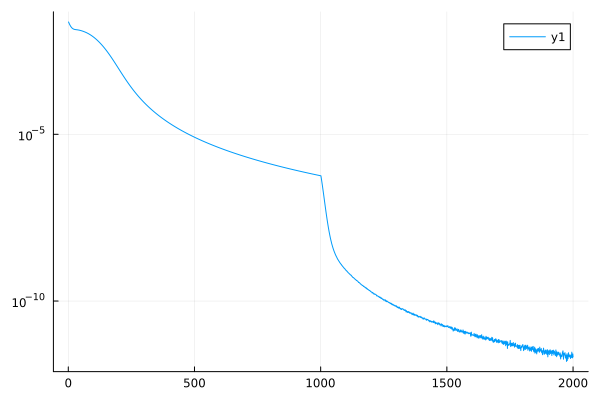

In [90]:
test1, lds1 = Petz_σ(test_dms, dim)
plot(lds1, yaxis=:log)

In [91]:
@show vec2dm(test1)
@show test_dms.s_dm - vec2dm(test1)

vec2dm(test1) = ComplexF32[0.43781078f0 + 0.0f0im 0.15506414f0 + 0.23558913f0im; 0.15506414f0 - 0.23558913f0im 0.5621892f0 + 0.0f0im]
test_dms.s_dm - vec2dm(test1) = ComplexF32[-0.00020873547f0 + 0.0f0im -0.00081038475f0 + 0.00048418343f0im; -0.00081038475f0 - 0.00048418343f0im 0.00020867586f0 + 0.0f0im]


2×2 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 -0.000208735+0.0im          -0.000810385+0.000484183im
 -0.000810385-0.000484183im   0.000208676+0.0im